# Face Generation

In this project, you'll define and train a DCGAN on a dataset of faces. Your goal is to get a generator network to generate *new* images of faces that look as realistic as possible!

The project will be broken down into a series of tasks from **loading in data to defining and training adversarial networks**. At the end of the notebook, you'll be able to visualize the results of your trained Generator to see how it performs; your generated samples should look like fairly realistic faces with small amounts of noise.

### Get the Data

You'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train your adversarial networks.

This dataset is more complex than the number datasets (like MNIST or SVHN) you've been working with, and so, you should prepare to define deeper networks and train them for a longer time to get good results. It is suggested that you utilize a GPU for training.

### Pre-processed Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is show below.

<img src='assets/processed_face_data.png' width=60% />

> If you are working locally, you can download this data [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

This is a zip file that you'll need to extract in the home directory of this notebook for further loading and processing. After extracting the data, you should be left with a directory of data `processed_celeba_small/`

In [1]:
# can comment out after executing
# !unzip processed_celeba_small.zip

In [2]:
data_dir = 'processed_celeba_small/'

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import problem_unittests as tests
#import helper

%matplotlib inline

## Visualize the CelebA Data

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations, you'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA data.

> There are a few other steps that you'll need to **transform** this data and create a **DataLoader**.

#### Exercise: Complete the following `get_dataloader` function, such that it satisfies these requirements:

* Your images should be square, Tensor images of size `image_size x image_size` in the x and y dimension.
* Your function should return a DataLoader that shuffles and batches these Tensor images.

#### ImageFolder

To create a dataset given a directory of images, it's recommended that you use PyTorch's [ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) wrapper, with a root directory `processed_celeba_small/` and data transformation passed in.

In [3]:
# necessary imports
import torch
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader

In [4]:
def get_dataloader(batch_size, image_size, data_dir='processed_celeba_small/'):
    """
    Batch the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """
    
    # TODO: Implement function and return a dataloader
    
    transform = transforms.Compose([transforms.Resize(image_size),
                                    transforms.ToTensor()])
    
    # get training and test directories
    image_path = './' + data_dir + 'celeba'
    
    # define datasets using ImageFolder
    train_dataset = datasets.ImageFolder(image_path, transform)

    # create and return DataLoaders
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    
    
    return train_loader


## Create a DataLoader

#### Exercise: Create a DataLoader `celeba_train_loader` with appropriate hyperparameters.

Call the above function and create a dataloader to view images. 
* You can decide on any reasonable `batch_size` parameter
* Your `image_size` **must be** `32`. Resizing the data to a smaller size will make for faster training, while still creating convincing images of faces!

In [5]:
# Define function hyperparameters
batch_size = 20
img_size = 32

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Call your function and get a dataloader
celeba_train_loader = get_dataloader(batch_size, img_size)


Next, you can view some images! You should seen square images of somewhat-centered faces.

Note: You'll need to convert the Tensor images into a NumPy type and transpose the dimensions to correctly display an image, suggested `imshow` code is below, but it may not be perfect.

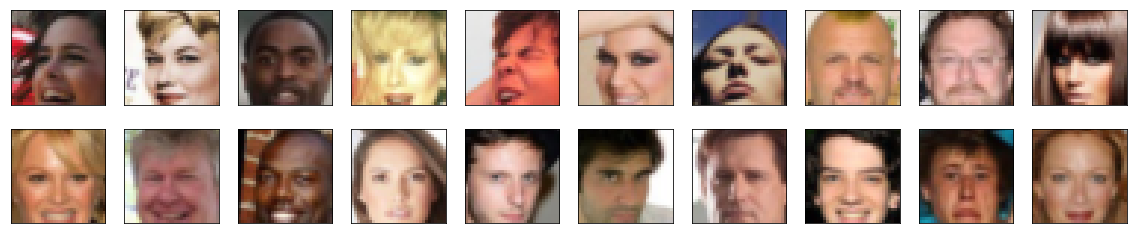

In [6]:
# helper display function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# obtain one batch of training images
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

#### Exercise: Pre-process your image data and scale it to a pixel range of -1 to 1

You need to do a bit of pre-processing; you know that the output of a `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [7]:
# current range
img = images[0]

print('Min: ', img.min())
print('Max: ', img.max())

Min:  tensor(1.00000e-02 *
       4.3137)
Max:  tensor(0.9882)


In [8]:
# TODO: Complete the scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    # assume x is scaled to (0, 1)
    # scale to feature_range and return scaled x
    min, max = feature_range
    x = x * (max - min) + min
    return x


In [9]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# check scaled range
# should be close to -1 to 1
img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-0.9137)
Max:  tensor(0.9765)


---
# Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator.

## Discriminator

Your first task will be to define the discriminator. This is a convolutional classifier like you've built before, only without any maxpooling layers. To deal with this complex data, it's suggested you use a deep network with **normalization**. You are also allowed to create any helper functions that may be useful.

#### Exercise: Complete the Discriminator class
* The inputs to the discriminator are 32x32x3 tensor images
* The output should be a single value that will indicate whether a given image is real or fake


In [10]:
import torch.nn as nn
import torch.nn.functional as F

In [11]:
# helper conv function
def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a convolutional layer, with optional batch normalization.
    """
    layers = []
    conv_layer = nn.Conv2d(in_channels, out_channels, 
                           kernel_size, stride, padding, bias=False)
    
    # append conv layer
    layers.append(conv_layer)

    if batch_norm:
        # append batchnorm layer
        layers.append(nn.BatchNorm2d(out_channels))
     
    # using Sequential container
    return nn.Sequential(*layers)

In [12]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim):
        """
        Initialize the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer
        """
        super(Discriminator, self).__init__()

        # complete init function
                # complete init function
        self.conv_dim = conv_dim

        # 32x32 input
        self.conv1 = conv(3, conv_dim, 4, batch_norm=False) # first layer, no batch_norm
        # 16x16 out
        self.conv2 = conv(conv_dim, conv_dim*2, 4)
        # 8x8 out
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4)
        # 4x4 out
        
        # final, fully-connected layer
        self.fc = nn.Linear(conv_dim*4*4*4, 1)

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: Discriminator logits; the output of the neural network
        """
        # define feedforward behavior
        # all hidden layers + leaky relu activation
        out = F.leaky_relu(self.conv1(x), 0.2)
        out = F.leaky_relu(self.conv2(out), 0.2)
        out = F.leaky_relu(self.conv3(out), 0.2)
        
        # flatten
        out = out.view(-1, self.conv_dim*4*4*4)
        
        # final output layer
        out = self.fc(out) 
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(Discriminator)

Tests Passed


## Generator

The generator should upsample an input and generate a *new* image of the same size as our training data `32x32x3`. This should be mostly transpose convolutional layers with normalization applied to the outputs.

#### Exercise: Complete the Generator class
* The inputs to the generator are vectors of some length `z_size`
* The output should be a image of shape `32x32x3`

In [13]:
# helper deconv function
def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a transposed-convolutional layer, with optional batch normalization.
    """
    # create a sequence of transpose + optional batch norm layers
    layers = []
    transpose_conv_layer = nn.ConvTranspose2d(in_channels, out_channels, 
                                              kernel_size, stride, padding, bias=False)
    # append transpose convolutional layer
    layers.append(transpose_conv_layer)
    
    if batch_norm:
        # append batchnorm layer
        layers.append(nn.BatchNorm2d(out_channels))
        
    return nn.Sequential(*layers)

In [14]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim):
        """
        Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        """
        super(Generator, self).__init__()

        # complete init function
        self.conv_dim = conv_dim
        
        # first, fully-connected layer
        self.fc = nn.Linear(z_size, conv_dim*4*4*4)

        # transpose conv layers
        self.t_conv1 = deconv(conv_dim*4, conv_dim*2, 4)
        self.t_conv2 = deconv(conv_dim*2, conv_dim, 4)
        self.t_conv3 = deconv(conv_dim, 3, 4, batch_norm=False)
        

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: A 32x32x3 Tensor image as output
        """
        # define feedforward behavior
        out = self.fc(x)
        out = out.view(-1, self.conv_dim*4, 4, 4) # (batch_size, depth, 4, 4)
        
        # hidden transpose conv layers + relu
        out = F.relu(self.t_conv1(out))
        out = F.relu(self.t_conv2(out))
        
        # last layer + tanh activation
        out = self.t_conv3(out)
        out = torch.tanh(out)
        
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(Generator)

Tests Passed


## Initialize the weights of your networks

To help your models converge, you should initialize the weights of the convolutional and linear layers in your model. From reading the [original DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf), they say:
> All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02.

So, your next task will be to define a weight initialization function that does just this!

You can refer back to the lesson on weight initialization or even consult existing model code, such as that from [the `networks.py` file in CycleGAN Github repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/networks.py) to help you complete this function.

#### Exercise: Complete the weight initialization function

* This should initialize only **convolutional** and **linear** layers
* Initialize the weights to a normal distribution, centered around 0, with a standard deviation of 0.02.
* The bias terms, if they exist, may be left alone or set to 0.

In [15]:
def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model .
    The weights are taken from a normal distribution 
    with mean = 0, std dev = 0.02.
    :param m: A module or layer in a network    
    """
    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__
    
    # TODO: Apply initial weights to convolutional and linear layers
    
    if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)

## Build complete network

Define your models' hyperparameters and instantiate the discriminator and generator from the classes defined above. Make sure you've passed in the correct input arguments.

In [16]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G


#### Exercise: Define model hyperparameters

In [17]:
# Define model hyperparams
d_conv_dim = 32
g_conv_dim = 32
z_size = 100

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=2048, out_features=1, bias=True)
)

Generator(
  (fc): Linear(in_features=100, out_features=2048, bias=True)
  (t_conv1): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (t_conv2): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias

### Training on GPU

Check if you can train on GPU. Here, we'll set this as a boolean variable `train_on_gpu`. Later, you'll be responsible for making sure that 
>* Models,
* Model inputs, and
* Loss function arguments

Are moved to GPU, where appropriate.

In [18]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import torch

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

Training on GPU!


---
## Discriminator and Generator Losses

Now we need to calculate the losses for both types of adversarial networks.

### Discriminator Losses

> * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 
* Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.


### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get the discriminator to *think* its generated images are *real*.

#### Exercise: Complete real and fake loss functions

**You may choose to use either cross entropy or a least squares error loss to complete the following `real_loss` and `fake_loss` functions.**

In [19]:
def real_loss(D_out, smooth=False):
    '''Calculates how close discriminator outputs are to being real.
       param, D_out: discriminator logits
       return: real loss'''
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    batch_size = D_out.size(0)
    # label smoothing
    if smooth:
        # smooth, real labels = 0.9
        labels = torch.ones(batch_size)*0.9
    else:
        labels = torch.ones(batch_size) # real labels = 1
    # move labels to GPU if available     
    if train_on_gpu:
        labels = labels.cuda()
    # binary cross entropy with logits loss
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    '''Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss'''
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size) # fake labels = 0
    if train_on_gpu:
        labels = labels.cuda()
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

## Optimizers

#### Exercise: Define optimizers for your Discriminator (D) and Generator (G)

Define optimizers for your models with appropriate hyperparameters.

In [20]:
import torch.optim as optim

# params
lr = 0.0002
beta1=0.5
beta2=0.999 # default value

# Create optimizers for the discriminator D and generator G
d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])

---
## Training

Training will involve alternating between training the discriminator and the generator. You'll use your functions `real_loss` and `fake_loss` to help you calculate the discriminator losses.

* You should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function


#### Saving Samples

You've been given some code to print out some loss statistics and save some generated "fake" samples.

#### Exercise: Complete the training function

Keep in mind that, if you've moved your models to GPU, you'll also have to move any model inputs to GPU.

In [21]:
def train(D, G, n_epochs, print_every=50):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)

            # ===============================================
            #         YOUR CODE HERE: TRAIN THE NETWORKS
            # ===============================================
            d_optimizer.zero_grad()
            
            if train_on_gpu:
                real_images = real_images.cuda()
                
            # 1. Train the discriminator on real and fake images
            
            # Compute the discriminator losses on real images
            D_real = D(real_images)
            d_real_loss = real_loss(D_real)
            
            
             # Train with fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            # move x to GPU, if available
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)
            
            D_fake = D(fake_images)
            d_fake_loss = fake_loss(D_fake)
            
            # add up loss and perform backprop
            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            d_optimizer.step()

            # 2. Train the generator with an adversarial loss
            
            g_optimizer.zero_grad()
        
            # Train with fake images and flipped labels

            # Generate fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)
            
            # Compute the discriminator losses on fake images 
            # using flipped labels!
            D_fake = D(fake_images)
            g_loss = real_loss(D_fake) # use real loss to flip labels

            # perform backprop
            g_loss.backward()
            g_optimizer.step()

            
            
            # ===============================================
            #              END OF YOUR CODE
            # ===============================================

            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))


        ## AFTER EACH EPOCH##    
        # this code assumes your generator is named G, feel free to change the name
        # generate and save sample, fake images
        G.eval() # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to training mode

    # Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    # finally return losses
    return losses

Set your number of training epochs and train your GAN!

In [22]:
import signal

from contextlib import contextmanager

import requests


DELAY = INTERVAL = 4 * 60  # interval time in seconds
MIN_DELAY = MIN_INTERVAL = 2 * 60
KEEPALIVE_URL = "https://nebula.udacity.com/api/v1/remote/keep-alive"
TOKEN_URL = "http://metadata.google.internal/computeMetadata/v1/instance/attributes/keep_alive_token"
TOKEN_HEADERS = {"Metadata-Flavor":"Google"}


def _request_handler(headers):
    def _handler(signum, frame):
        requests.request("POST", KEEPALIVE_URL, headers=headers)
    return _handler



@contextmanager
def active_session(delay=DELAY, interval=INTERVAL):
    """
    Example:

    from workspace_utils import active session

    with active_session():
        # do long-running work here
    """
    token = requests.request("GET", TOKEN_URL, headers=TOKEN_HEADERS).text
    headers = {'Authorization': "STAR " + token}
    delay = max(delay, MIN_DELAY)
    interval = max(interval, MIN_INTERVAL)
    original_handler = signal.getsignal(signal.SIGALRM)
    try:
        signal.signal(signal.SIGALRM, _request_handler(headers))
        signal.setitimer(signal.ITIMER_REAL, delay, interval)
        yield
    finally:
        signal.signal(signal.SIGALRM, original_handler)
        signal.setitimer(signal.ITIMER_REAL, 0)

In [23]:
# set number of epochs 
n_epochs = 100


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# call training function
with active_session():
    losses = train(D, G, n_epochs=n_epochs)

Epoch [    1/  100] | d_loss: 1.5143 | g_loss: 0.6784
Epoch [    1/  100] | d_loss: 0.3630 | g_loss: 2.3694
Epoch [    1/  100] | d_loss: 0.1765 | g_loss: 3.0871
Epoch [    1/  100] | d_loss: 0.2339 | g_loss: 2.7525
Epoch [    1/  100] | d_loss: 0.2555 | g_loss: 3.1361
Epoch [    1/  100] | d_loss: 0.1236 | g_loss: 2.9236
Epoch [    1/  100] | d_loss: 0.5037 | g_loss: 2.8758
Epoch [    1/  100] | d_loss: 0.6324 | g_loss: 2.9957
Epoch [    1/  100] | d_loss: 0.5354 | g_loss: 1.3944
Epoch [    1/  100] | d_loss: 0.6274 | g_loss: 1.3949
Epoch [    1/  100] | d_loss: 0.7421 | g_loss: 2.4855
Epoch [    1/  100] | d_loss: 0.5340 | g_loss: 2.4838
Epoch [    1/  100] | d_loss: 0.8185 | g_loss: 2.8413
Epoch [    1/  100] | d_loss: 0.7512 | g_loss: 1.4140
Epoch [    1/  100] | d_loss: 1.1815 | g_loss: 3.3534
Epoch [    1/  100] | d_loss: 0.9409 | g_loss: 2.3474
Epoch [    1/  100] | d_loss: 1.1113 | g_loss: 0.6536
Epoch [    1/  100] | d_loss: 0.7161 | g_loss: 2.2682
Epoch [    1/  100] | d_loss

Epoch [    3/  100] | d_loss: 0.7694 | g_loss: 1.0948
Epoch [    3/  100] | d_loss: 0.9913 | g_loss: 1.2987
Epoch [    3/  100] | d_loss: 1.0213 | g_loss: 1.1517
Epoch [    3/  100] | d_loss: 0.8614 | g_loss: 1.0572
Epoch [    3/  100] | d_loss: 1.1170 | g_loss: 0.9834
Epoch [    3/  100] | d_loss: 0.9050 | g_loss: 1.6367
Epoch [    3/  100] | d_loss: 0.7517 | g_loss: 1.1837
Epoch [    3/  100] | d_loss: 1.3023 | g_loss: 0.3302
Epoch [    3/  100] | d_loss: 0.6713 | g_loss: 1.7792
Epoch [    3/  100] | d_loss: 1.0072 | g_loss: 1.3005
Epoch [    3/  100] | d_loss: 1.1580 | g_loss: 1.3125
Epoch [    3/  100] | d_loss: 1.0222 | g_loss: 0.6940
Epoch [    3/  100] | d_loss: 0.7912 | g_loss: 0.8867
Epoch [    3/  100] | d_loss: 1.3352 | g_loss: 1.2240
Epoch [    3/  100] | d_loss: 1.2908 | g_loss: 1.5396
Epoch [    3/  100] | d_loss: 1.1789 | g_loss: 1.6031
Epoch [    3/  100] | d_loss: 0.9511 | g_loss: 1.3017
Epoch [    3/  100] | d_loss: 1.1062 | g_loss: 1.0816
Epoch [    3/  100] | d_loss

Epoch [    6/  100] | d_loss: 1.0472 | g_loss: 1.5336
Epoch [    6/  100] | d_loss: 0.8037 | g_loss: 1.9432
Epoch [    6/  100] | d_loss: 0.7132 | g_loss: 1.1803
Epoch [    6/  100] | d_loss: 0.9320 | g_loss: 1.6498
Epoch [    6/  100] | d_loss: 1.1422 | g_loss: 1.2296
Epoch [    6/  100] | d_loss: 0.8668 | g_loss: 1.0027
Epoch [    6/  100] | d_loss: 1.0109 | g_loss: 1.1123
Epoch [    6/  100] | d_loss: 0.8733 | g_loss: 1.4334
Epoch [    6/  100] | d_loss: 0.9920 | g_loss: 1.1390
Epoch [    6/  100] | d_loss: 1.1983 | g_loss: 1.8170
Epoch [    6/  100] | d_loss: 0.9211 | g_loss: 1.6908
Epoch [    6/  100] | d_loss: 0.8280 | g_loss: 1.2072
Epoch [    6/  100] | d_loss: 0.6758 | g_loss: 1.7150
Epoch [    6/  100] | d_loss: 0.8412 | g_loss: 2.6610
Epoch [    6/  100] | d_loss: 0.8295 | g_loss: 2.2732
Epoch [    6/  100] | d_loss: 0.7183 | g_loss: 1.9902
Epoch [    6/  100] | d_loss: 0.9620 | g_loss: 1.0056
Epoch [    6/  100] | d_loss: 0.8923 | g_loss: 1.7835
Epoch [    6/  100] | d_loss

Epoch [    8/  100] | d_loss: 1.1225 | g_loss: 2.4501
Epoch [    8/  100] | d_loss: 1.0018 | g_loss: 2.0347
Epoch [    8/  100] | d_loss: 1.1106 | g_loss: 1.1060
Epoch [    8/  100] | d_loss: 0.8719 | g_loss: 0.3442
Epoch [    8/  100] | d_loss: 0.7104 | g_loss: 1.2428
Epoch [    8/  100] | d_loss: 0.7402 | g_loss: 1.3621
Epoch [    8/  100] | d_loss: 0.7699 | g_loss: 0.7315
Epoch [    8/  100] | d_loss: 0.9228 | g_loss: 1.7555
Epoch [    9/  100] | d_loss: 0.5614 | g_loss: 1.1425
Epoch [    9/  100] | d_loss: 0.7205 | g_loss: 1.5678
Epoch [    9/  100] | d_loss: 0.7666 | g_loss: 0.7716
Epoch [    9/  100] | d_loss: 0.7414 | g_loss: 1.7152
Epoch [    9/  100] | d_loss: 0.4882 | g_loss: 2.0448
Epoch [    9/  100] | d_loss: 1.2747 | g_loss: 1.7838
Epoch [    9/  100] | d_loss: 0.5787 | g_loss: 2.8844
Epoch [    9/  100] | d_loss: 0.4682 | g_loss: 2.3457
Epoch [    9/  100] | d_loss: 0.9849 | g_loss: 0.7389
Epoch [    9/  100] | d_loss: 0.9076 | g_loss: 0.9525
Epoch [    9/  100] | d_loss

Epoch [   11/  100] | d_loss: 0.6185 | g_loss: 1.9061
Epoch [   11/  100] | d_loss: 0.3230 | g_loss: 1.9434
Epoch [   11/  100] | d_loss: 0.2959 | g_loss: 1.7265
Epoch [   11/  100] | d_loss: 0.5642 | g_loss: 1.7695
Epoch [   11/  100] | d_loss: 0.6613 | g_loss: 2.3044
Epoch [   11/  100] | d_loss: 0.3148 | g_loss: 1.6126
Epoch [   11/  100] | d_loss: 1.0053 | g_loss: 2.3112
Epoch [   11/  100] | d_loss: 0.6966 | g_loss: 2.4210
Epoch [   11/  100] | d_loss: 0.7618 | g_loss: 1.4768
Epoch [   11/  100] | d_loss: 0.9527 | g_loss: 0.6646
Epoch [   11/  100] | d_loss: 0.5499 | g_loss: 2.8984
Epoch [   11/  100] | d_loss: 0.7778 | g_loss: 1.2662
Epoch [   11/  100] | d_loss: 0.7548 | g_loss: 2.8620
Epoch [   11/  100] | d_loss: 0.5913 | g_loss: 1.5229
Epoch [   11/  100] | d_loss: 0.6917 | g_loss: 1.9731
Epoch [   11/  100] | d_loss: 0.5437 | g_loss: 2.3110
Epoch [   11/  100] | d_loss: 0.4404 | g_loss: 1.9063
Epoch [   11/  100] | d_loss: 0.4073 | g_loss: 2.1785
Epoch [   11/  100] | d_loss

Epoch [   14/  100] | d_loss: 0.9148 | g_loss: 3.6921
Epoch [   14/  100] | d_loss: 0.2549 | g_loss: 2.0417
Epoch [   14/  100] | d_loss: 0.1626 | g_loss: 1.3258
Epoch [   14/  100] | d_loss: 0.6364 | g_loss: 2.4116
Epoch [   14/  100] | d_loss: 0.4865 | g_loss: 2.7754
Epoch [   14/  100] | d_loss: 0.2074 | g_loss: 3.2260
Epoch [   14/  100] | d_loss: 0.1292 | g_loss: 1.3338
Epoch [   14/  100] | d_loss: 0.4936 | g_loss: 2.1049
Epoch [   14/  100] | d_loss: 0.2445 | g_loss: 2.3757
Epoch [   14/  100] | d_loss: 0.1300 | g_loss: 3.0412
Epoch [   14/  100] | d_loss: 0.2985 | g_loss: 2.5643
Epoch [   14/  100] | d_loss: 0.2661 | g_loss: 2.2127
Epoch [   14/  100] | d_loss: 0.2992 | g_loss: 2.5625
Epoch [   14/  100] | d_loss: 0.8168 | g_loss: 3.2021
Epoch [   14/  100] | d_loss: 0.5437 | g_loss: 2.0878
Epoch [   14/  100] | d_loss: 0.3597 | g_loss: 3.4339
Epoch [   14/  100] | d_loss: 0.1764 | g_loss: 2.4779
Epoch [   14/  100] | d_loss: 0.4044 | g_loss: 1.7105
Epoch [   14/  100] | d_loss

Epoch [   16/  100] | d_loss: 0.2756 | g_loss: 2.5439
Epoch [   16/  100] | d_loss: 0.1752 | g_loss: 3.6063
Epoch [   16/  100] | d_loss: 0.5305 | g_loss: 3.7136
Epoch [   16/  100] | d_loss: 0.2800 | g_loss: 2.7978
Epoch [   16/  100] | d_loss: 0.4851 | g_loss: 3.5890
Epoch [   16/  100] | d_loss: 0.5274 | g_loss: 2.4115
Epoch [   16/  100] | d_loss: 0.4469 | g_loss: 3.7595
Epoch [   16/  100] | d_loss: 0.5795 | g_loss: 1.5581
Epoch [   16/  100] | d_loss: 0.8149 | g_loss: 2.8303
Epoch [   16/  100] | d_loss: 0.3818 | g_loss: 3.4766
Epoch [   16/  100] | d_loss: 0.1118 | g_loss: 3.5727
Epoch [   16/  100] | d_loss: 0.3304 | g_loss: 2.8593
Epoch [   16/  100] | d_loss: 0.2741 | g_loss: 1.4191
Epoch [   16/  100] | d_loss: 0.3977 | g_loss: 2.6478
Epoch [   16/  100] | d_loss: 0.4824 | g_loss: 4.2651
Epoch [   16/  100] | d_loss: 0.8124 | g_loss: 3.3540
Epoch [   17/  100] | d_loss: 0.8688 | g_loss: 1.3257
Epoch [   17/  100] | d_loss: 0.5017 | g_loss: 3.6403
Epoch [   17/  100] | d_loss

Epoch [   19/  100] | d_loss: 0.2207 | g_loss: 2.5039
Epoch [   19/  100] | d_loss: 0.2569 | g_loss: 2.3923
Epoch [   19/  100] | d_loss: 0.4864 | g_loss: 2.8237
Epoch [   19/  100] | d_loss: 0.1626 | g_loss: 4.1399
Epoch [   19/  100] | d_loss: 0.2771 | g_loss: 1.5480
Epoch [   19/  100] | d_loss: 0.4382 | g_loss: 2.6779
Epoch [   19/  100] | d_loss: 0.2494 | g_loss: 2.0475
Epoch [   19/  100] | d_loss: 0.5524 | g_loss: 2.0940
Epoch [   19/  100] | d_loss: 0.0864 | g_loss: 3.1624
Epoch [   19/  100] | d_loss: 0.2308 | g_loss: 3.0452
Epoch [   19/  100] | d_loss: 0.7085 | g_loss: 3.9593
Epoch [   19/  100] | d_loss: 0.3748 | g_loss: 4.8811
Epoch [   19/  100] | d_loss: 0.1693 | g_loss: 2.7769
Epoch [   19/  100] | d_loss: 0.6120 | g_loss: 2.4285
Epoch [   19/  100] | d_loss: 0.5979 | g_loss: 2.6736
Epoch [   19/  100] | d_loss: 0.3612 | g_loss: 2.7842
Epoch [   19/  100] | d_loss: 0.5522 | g_loss: 3.3968
Epoch [   19/  100] | d_loss: 0.3290 | g_loss: 2.9433
Epoch [   19/  100] | d_loss

Epoch [   21/  100] | d_loss: 0.1483 | g_loss: 2.7674
Epoch [   21/  100] | d_loss: 0.2741 | g_loss: 2.9014
Epoch [   22/  100] | d_loss: 0.2435 | g_loss: 1.6867
Epoch [   22/  100] | d_loss: 0.0471 | g_loss: 5.3383
Epoch [   22/  100] | d_loss: 0.1683 | g_loss: 3.3561
Epoch [   22/  100] | d_loss: 0.1506 | g_loss: 2.6400
Epoch [   22/  100] | d_loss: 0.6513 | g_loss: 3.8822
Epoch [   22/  100] | d_loss: 0.2284 | g_loss: 3.1633
Epoch [   22/  100] | d_loss: 0.1347 | g_loss: 2.3428
Epoch [   22/  100] | d_loss: 0.7800 | g_loss: 3.5673
Epoch [   22/  100] | d_loss: 0.6750 | g_loss: 3.4296
Epoch [   22/  100] | d_loss: 1.2030 | g_loss: 3.7415
Epoch [   22/  100] | d_loss: 0.0533 | g_loss: 4.6217
Epoch [   22/  100] | d_loss: 0.2471 | g_loss: 2.3944
Epoch [   22/  100] | d_loss: 0.4148 | g_loss: 3.1267
Epoch [   22/  100] | d_loss: 0.9814 | g_loss: 1.7190
Epoch [   22/  100] | d_loss: 0.5777 | g_loss: 4.1602
Epoch [   22/  100] | d_loss: 0.1923 | g_loss: 3.2578
Epoch [   22/  100] | d_loss

Epoch [   24/  100] | d_loss: 0.9231 | g_loss: 2.3488
Epoch [   24/  100] | d_loss: 0.1812 | g_loss: 3.6415
Epoch [   24/  100] | d_loss: 0.1402 | g_loss: 3.5360
Epoch [   24/  100] | d_loss: 0.3691 | g_loss: 3.7973
Epoch [   24/  100] | d_loss: 0.9642 | g_loss: 2.0974
Epoch [   24/  100] | d_loss: 0.2529 | g_loss: 1.7602
Epoch [   24/  100] | d_loss: 0.7386 | g_loss: 2.0396
Epoch [   24/  100] | d_loss: 0.1390 | g_loss: 3.5347
Epoch [   24/  100] | d_loss: 0.7633 | g_loss: 2.8940
Epoch [   24/  100] | d_loss: 0.2225 | g_loss: 2.7145
Epoch [   24/  100] | d_loss: 0.9514 | g_loss: 2.2483
Epoch [   24/  100] | d_loss: 0.1427 | g_loss: 3.4426
Epoch [   24/  100] | d_loss: 0.3093 | g_loss: 3.7652
Epoch [   24/  100] | d_loss: 0.7747 | g_loss: 3.0115
Epoch [   24/  100] | d_loss: 0.4884 | g_loss: 2.1616
Epoch [   24/  100] | d_loss: 0.6321 | g_loss: 3.9679
Epoch [   24/  100] | d_loss: 0.3610 | g_loss: 3.7627
Epoch [   24/  100] | d_loss: 0.1027 | g_loss: 3.0422
Epoch [   24/  100] | d_loss

Epoch [   27/  100] | d_loss: 0.3547 | g_loss: 2.5314
Epoch [   27/  100] | d_loss: 0.2166 | g_loss: 2.3820
Epoch [   27/  100] | d_loss: 0.4994 | g_loss: 0.3453
Epoch [   27/  100] | d_loss: 0.3191 | g_loss: 4.2158
Epoch [   27/  100] | d_loss: 0.1969 | g_loss: 3.8570
Epoch [   27/  100] | d_loss: 0.3392 | g_loss: 4.2308
Epoch [   27/  100] | d_loss: 0.0923 | g_loss: 4.0458
Epoch [   27/  100] | d_loss: 0.3078 | g_loss: 3.4446
Epoch [   27/  100] | d_loss: 0.3825 | g_loss: 3.8842
Epoch [   27/  100] | d_loss: 0.3165 | g_loss: 2.2567
Epoch [   27/  100] | d_loss: 0.2099 | g_loss: 3.0339
Epoch [   27/  100] | d_loss: 0.1555 | g_loss: 3.0525
Epoch [   27/  100] | d_loss: 0.2823 | g_loss: 5.0075
Epoch [   27/  100] | d_loss: 0.1451 | g_loss: 4.8306
Epoch [   27/  100] | d_loss: 0.1159 | g_loss: 2.7944
Epoch [   27/  100] | d_loss: 0.6383 | g_loss: 2.1924
Epoch [   27/  100] | d_loss: 0.3366 | g_loss: 1.1405
Epoch [   27/  100] | d_loss: 0.4880 | g_loss: 2.0980
Epoch [   27/  100] | d_loss

Epoch [   29/  100] | d_loss: 0.4940 | g_loss: 1.7931
Epoch [   29/  100] | d_loss: 0.6459 | g_loss: 2.8004
Epoch [   29/  100] | d_loss: 0.2802 | g_loss: 2.5889
Epoch [   29/  100] | d_loss: 0.1431 | g_loss: 4.0806
Epoch [   29/  100] | d_loss: 0.2679 | g_loss: 3.2275
Epoch [   29/  100] | d_loss: 0.1634 | g_loss: 2.3077
Epoch [   29/  100] | d_loss: 0.6955 | g_loss: 2.6090
Epoch [   29/  100] | d_loss: 0.4825 | g_loss: 2.5276
Epoch [   29/  100] | d_loss: 0.6513 | g_loss: 4.0656
Epoch [   29/  100] | d_loss: 0.1733 | g_loss: 4.2338
Epoch [   30/  100] | d_loss: 0.1773 | g_loss: 2.7533
Epoch [   30/  100] | d_loss: 0.0528 | g_loss: 2.7748
Epoch [   30/  100] | d_loss: 0.8417 | g_loss: 1.5624
Epoch [   30/  100] | d_loss: 0.3787 | g_loss: 3.6323
Epoch [   30/  100] | d_loss: 0.4900 | g_loss: 4.1400
Epoch [   30/  100] | d_loss: 0.2604 | g_loss: 4.4482
Epoch [   30/  100] | d_loss: 0.7479 | g_loss: 2.8790
Epoch [   30/  100] | d_loss: 0.2451 | g_loss: 2.4255
Epoch [   30/  100] | d_loss

Epoch [   32/  100] | d_loss: 0.0614 | g_loss: 4.6771
Epoch [   32/  100] | d_loss: 0.2609 | g_loss: 1.7703
Epoch [   32/  100] | d_loss: 0.2118 | g_loss: 3.2423
Epoch [   32/  100] | d_loss: 0.1653 | g_loss: 4.6863
Epoch [   32/  100] | d_loss: 0.1189 | g_loss: 3.3127
Epoch [   32/  100] | d_loss: 0.0663 | g_loss: 4.3949
Epoch [   32/  100] | d_loss: 0.2779 | g_loss: 2.4826
Epoch [   32/  100] | d_loss: 0.2629 | g_loss: 3.0618
Epoch [   32/  100] | d_loss: 0.1023 | g_loss: 3.5459
Epoch [   32/  100] | d_loss: 0.5154 | g_loss: 1.1192
Epoch [   32/  100] | d_loss: 0.3296 | g_loss: 2.8263
Epoch [   32/  100] | d_loss: 0.3764 | g_loss: 2.9830
Epoch [   32/  100] | d_loss: 0.2733 | g_loss: 2.1162
Epoch [   32/  100] | d_loss: 0.2517 | g_loss: 3.7182
Epoch [   32/  100] | d_loss: 0.1545 | g_loss: 3.5894
Epoch [   32/  100] | d_loss: 0.2620 | g_loss: 5.4192
Epoch [   32/  100] | d_loss: 0.5325 | g_loss: 5.6253
Epoch [   32/  100] | d_loss: 0.6510 | g_loss: 4.4140
Epoch [   32/  100] | d_loss

Epoch [   35/  100] | d_loss: 1.1231 | g_loss: 2.7341
Epoch [   35/  100] | d_loss: 0.2460 | g_loss: 3.3306
Epoch [   35/  100] | d_loss: 0.1663 | g_loss: 3.8731
Epoch [   35/  100] | d_loss: 1.3114 | g_loss: 1.5281
Epoch [   35/  100] | d_loss: 0.1458 | g_loss: 4.0223
Epoch [   35/  100] | d_loss: 0.0375 | g_loss: 5.2042
Epoch [   35/  100] | d_loss: 0.9983 | g_loss: 0.4730
Epoch [   35/  100] | d_loss: 0.4381 | g_loss: 3.7723
Epoch [   35/  100] | d_loss: 0.0649 | g_loss: 4.3061
Epoch [   35/  100] | d_loss: 0.1857 | g_loss: 5.7051
Epoch [   35/  100] | d_loss: 0.1907 | g_loss: 4.4437
Epoch [   35/  100] | d_loss: 0.0424 | g_loss: 5.4401
Epoch [   35/  100] | d_loss: 0.2785 | g_loss: 5.5075
Epoch [   35/  100] | d_loss: 0.2456 | g_loss: 3.7098
Epoch [   35/  100] | d_loss: 0.1154 | g_loss: 4.8283
Epoch [   35/  100] | d_loss: 0.1269 | g_loss: 3.5136
Epoch [   35/  100] | d_loss: 0.4910 | g_loss: 5.1059
Epoch [   35/  100] | d_loss: 0.1927 | g_loss: 3.4823
Epoch [   35/  100] | d_loss

Epoch [   37/  100] | d_loss: 0.1939 | g_loss: 5.4416
Epoch [   37/  100] | d_loss: 0.1455 | g_loss: 3.8022
Epoch [   37/  100] | d_loss: 0.2161 | g_loss: 4.1763
Epoch [   37/  100] | d_loss: 0.2730 | g_loss: 3.8345
Epoch [   37/  100] | d_loss: 0.1187 | g_loss: 4.1006
Epoch [   37/  100] | d_loss: 0.1096 | g_loss: 2.8990
Epoch [   37/  100] | d_loss: 0.4487 | g_loss: 4.3195
Epoch [   37/  100] | d_loss: 0.7711 | g_loss: 1.3249
Epoch [   37/  100] | d_loss: 1.1024 | g_loss: 3.2439
Epoch [   37/  100] | d_loss: 0.2759 | g_loss: 4.2331
Epoch [   37/  100] | d_loss: 0.3459 | g_loss: 2.0897
Epoch [   37/  100] | d_loss: 0.3086 | g_loss: 3.9742
Epoch [   37/  100] | d_loss: 0.3989 | g_loss: 3.1460
Epoch [   37/  100] | d_loss: 1.3882 | g_loss: 2.7510
Epoch [   37/  100] | d_loss: 0.7089 | g_loss: 5.3312
Epoch [   37/  100] | d_loss: 0.1917 | g_loss: 2.0295
Epoch [   37/  100] | d_loss: 0.1754 | g_loss: 2.6437
Epoch [   37/  100] | d_loss: 0.1506 | g_loss: 2.5409
Epoch [   38/  100] | d_loss

Epoch [   40/  100] | d_loss: 0.6965 | g_loss: 2.5111
Epoch [   40/  100] | d_loss: 0.2291 | g_loss: 2.9111
Epoch [   40/  100] | d_loss: 0.3867 | g_loss: 2.4868
Epoch [   40/  100] | d_loss: 0.2968 | g_loss: 3.8568
Epoch [   40/  100] | d_loss: 0.0723 | g_loss: 2.7832
Epoch [   40/  100] | d_loss: 1.7063 | g_loss: 8.3060
Epoch [   40/  100] | d_loss: 0.1166 | g_loss: 4.8089
Epoch [   40/  100] | d_loss: 0.1397 | g_loss: 4.8936
Epoch [   40/  100] | d_loss: 0.1701 | g_loss: 4.5867
Epoch [   40/  100] | d_loss: 0.0818 | g_loss: 4.6484
Epoch [   40/  100] | d_loss: 0.4290 | g_loss: 3.1979
Epoch [   40/  100] | d_loss: 0.0488 | g_loss: 6.3491
Epoch [   40/  100] | d_loss: 0.0527 | g_loss: 4.3683
Epoch [   40/  100] | d_loss: 0.1001 | g_loss: 3.1756
Epoch [   40/  100] | d_loss: 0.3275 | g_loss: 4.7266
Epoch [   40/  100] | d_loss: 0.1492 | g_loss: 5.8236
Epoch [   40/  100] | d_loss: 0.2002 | g_loss: 1.9309
Epoch [   40/  100] | d_loss: 0.0265 | g_loss: 6.3777
Epoch [   40/  100] | d_loss

Epoch [   42/  100] | d_loss: 0.1702 | g_loss: 4.5377
Epoch [   42/  100] | d_loss: 0.2606 | g_loss: 4.6159
Epoch [   42/  100] | d_loss: 0.4341 | g_loss: 2.8965
Epoch [   42/  100] | d_loss: 0.1839 | g_loss: 2.2896
Epoch [   43/  100] | d_loss: 0.1074 | g_loss: 5.7736
Epoch [   43/  100] | d_loss: 0.1299 | g_loss: 3.9891
Epoch [   43/  100] | d_loss: 0.1990 | g_loss: 3.6180
Epoch [   43/  100] | d_loss: 0.0910 | g_loss: 4.1782
Epoch [   43/  100] | d_loss: 0.1251 | g_loss: 2.3863
Epoch [   43/  100] | d_loss: 0.1113 | g_loss: 3.6235
Epoch [   43/  100] | d_loss: 0.2326 | g_loss: 3.3682
Epoch [   43/  100] | d_loss: 0.0134 | g_loss: 5.8887
Epoch [   43/  100] | d_loss: 0.0396 | g_loss: 3.9384
Epoch [   43/  100] | d_loss: 0.2415 | g_loss: 4.0254
Epoch [   43/  100] | d_loss: 0.0711 | g_loss: 2.8625
Epoch [   43/  100] | d_loss: 0.5354 | g_loss: 2.9288
Epoch [   43/  100] | d_loss: 1.0973 | g_loss: 1.7392
Epoch [   43/  100] | d_loss: 0.0935 | g_loss: 4.0589
Epoch [   43/  100] | d_loss

Epoch [   45/  100] | d_loss: 0.0818 | g_loss: 5.9968
Epoch [   45/  100] | d_loss: 0.3670 | g_loss: 3.7905
Epoch [   45/  100] | d_loss: 0.1479 | g_loss: 4.8248
Epoch [   45/  100] | d_loss: 0.1977 | g_loss: 5.7270
Epoch [   45/  100] | d_loss: 0.0670 | g_loss: 4.5219
Epoch [   45/  100] | d_loss: 0.0882 | g_loss: 4.0963
Epoch [   45/  100] | d_loss: 0.1604 | g_loss: 3.8167
Epoch [   45/  100] | d_loss: 0.1674 | g_loss: 2.1611
Epoch [   45/  100] | d_loss: 0.4199 | g_loss: 1.5133
Epoch [   45/  100] | d_loss: 0.1114 | g_loss: 3.2165
Epoch [   45/  100] | d_loss: 0.6952 | g_loss: 3.8733
Epoch [   45/  100] | d_loss: 0.0463 | g_loss: 5.4195
Epoch [   45/  100] | d_loss: 0.0418 | g_loss: 3.7054
Epoch [   45/  100] | d_loss: 0.8598 | g_loss: 4.8574
Epoch [   45/  100] | d_loss: 0.4629 | g_loss: 4.2753
Epoch [   45/  100] | d_loss: 0.3129 | g_loss: 4.5149
Epoch [   45/  100] | d_loss: 0.0879 | g_loss: 4.5882
Epoch [   45/  100] | d_loss: 0.0386 | g_loss: 4.5363
Epoch [   45/  100] | d_loss

Epoch [   48/  100] | d_loss: 0.4035 | g_loss: 3.4803
Epoch [   48/  100] | d_loss: 0.0998 | g_loss: 2.4232
Epoch [   48/  100] | d_loss: 0.5662 | g_loss: 5.4023
Epoch [   48/  100] | d_loss: 0.2021 | g_loss: 2.3386
Epoch [   48/  100] | d_loss: 0.3131 | g_loss: 4.9160
Epoch [   48/  100] | d_loss: 0.3086 | g_loss: 3.3437
Epoch [   48/  100] | d_loss: 0.2910 | g_loss: 4.4442
Epoch [   48/  100] | d_loss: 0.4601 | g_loss: 4.5968
Epoch [   48/  100] | d_loss: 0.3191 | g_loss: 6.7119
Epoch [   48/  100] | d_loss: 0.1220 | g_loss: 4.6082
Epoch [   48/  100] | d_loss: 0.4431 | g_loss: 3.5495
Epoch [   48/  100] | d_loss: 0.0189 | g_loss: 4.6355
Epoch [   48/  100] | d_loss: 0.0555 | g_loss: 2.5386
Epoch [   48/  100] | d_loss: 0.7743 | g_loss: 1.8235
Epoch [   48/  100] | d_loss: 0.5103 | g_loss: 2.8695
Epoch [   48/  100] | d_loss: 0.1099 | g_loss: 3.1228
Epoch [   48/  100] | d_loss: 0.0847 | g_loss: 5.3169
Epoch [   48/  100] | d_loss: 0.1278 | g_loss: 5.9687
Epoch [   48/  100] | d_loss

Epoch [   50/  100] | d_loss: 0.1411 | g_loss: 3.2206
Epoch [   50/  100] | d_loss: 0.0642 | g_loss: 3.7854
Epoch [   50/  100] | d_loss: 0.7196 | g_loss: 4.4824
Epoch [   50/  100] | d_loss: 0.2508 | g_loss: 3.4187
Epoch [   50/  100] | d_loss: 0.1364 | g_loss: 5.1389
Epoch [   50/  100] | d_loss: 0.1949 | g_loss: 4.1274
Epoch [   50/  100] | d_loss: 0.0192 | g_loss: 5.8532
Epoch [   50/  100] | d_loss: 0.0364 | g_loss: 2.2360
Epoch [   50/  100] | d_loss: 0.0620 | g_loss: 5.3409
Epoch [   50/  100] | d_loss: 0.2399 | g_loss: 4.6535
Epoch [   50/  100] | d_loss: 0.1308 | g_loss: 4.2883
Epoch [   50/  100] | d_loss: 0.1204 | g_loss: 5.8617
Epoch [   51/  100] | d_loss: 0.0636 | g_loss: 5.3270
Epoch [   51/  100] | d_loss: 0.2308 | g_loss: 5.0041
Epoch [   51/  100] | d_loss: 0.8082 | g_loss: 3.1731
Epoch [   51/  100] | d_loss: 0.3180 | g_loss: 3.5350
Epoch [   51/  100] | d_loss: 0.0635 | g_loss: 2.8857
Epoch [   51/  100] | d_loss: 0.1318 | g_loss: 5.3946
Epoch [   51/  100] | d_loss

Epoch [   53/  100] | d_loss: 0.1743 | g_loss: 4.9910
Epoch [   53/  100] | d_loss: 0.1182 | g_loss: 5.6159
Epoch [   53/  100] | d_loss: 0.1070 | g_loss: 8.0745
Epoch [   53/  100] | d_loss: 0.0689 | g_loss: 5.0483
Epoch [   53/  100] | d_loss: 0.0577 | g_loss: 3.7005
Epoch [   53/  100] | d_loss: 0.0665 | g_loss: 4.9484
Epoch [   53/  100] | d_loss: 0.6723 | g_loss: 3.8782
Epoch [   53/  100] | d_loss: 0.1853 | g_loss: 7.2371
Epoch [   53/  100] | d_loss: 0.2107 | g_loss: 5.2741
Epoch [   53/  100] | d_loss: 0.0247 | g_loss: 5.6239
Epoch [   53/  100] | d_loss: 0.1500 | g_loss: 7.2674
Epoch [   53/  100] | d_loss: 0.0990 | g_loss: 7.9910
Epoch [   53/  100] | d_loss: 0.1145 | g_loss: 5.7364
Epoch [   53/  100] | d_loss: 0.0511 | g_loss: 2.6821
Epoch [   53/  100] | d_loss: 0.4484 | g_loss: 2.9702
Epoch [   53/  100] | d_loss: 0.4874 | g_loss: 3.5897
Epoch [   53/  100] | d_loss: 0.2842 | g_loss: 4.4895
Epoch [   53/  100] | d_loss: 0.4708 | g_loss: 2.5132
Epoch [   53/  100] | d_loss

Epoch [   56/  100] | d_loss: 0.1104 | g_loss: 6.9464
Epoch [   56/  100] | d_loss: 0.5625 | g_loss: 6.8509
Epoch [   56/  100] | d_loss: 0.1019 | g_loss: 6.2955
Epoch [   56/  100] | d_loss: 0.1195 | g_loss: 4.5113
Epoch [   56/  100] | d_loss: 0.0920 | g_loss: 4.9754
Epoch [   56/  100] | d_loss: 0.2479 | g_loss: 4.5648
Epoch [   56/  100] | d_loss: 0.1541 | g_loss: 4.8326
Epoch [   56/  100] | d_loss: 0.2397 | g_loss: 4.2379
Epoch [   56/  100] | d_loss: 0.1738 | g_loss: 4.2563
Epoch [   56/  100] | d_loss: 0.0791 | g_loss: 6.7296
Epoch [   56/  100] | d_loss: 0.4819 | g_loss: 5.3099
Epoch [   56/  100] | d_loss: 0.6018 | g_loss: 7.1699
Epoch [   56/  100] | d_loss: 0.3521 | g_loss: 3.1466
Epoch [   56/  100] | d_loss: 0.1069 | g_loss: 4.1499
Epoch [   56/  100] | d_loss: 0.6985 | g_loss: 2.7801
Epoch [   56/  100] | d_loss: 0.2692 | g_loss: 4.2585
Epoch [   56/  100] | d_loss: 0.1081 | g_loss: 4.8993
Epoch [   56/  100] | d_loss: 0.2781 | g_loss: 4.2839
Epoch [   56/  100] | d_loss

Epoch [   58/  100] | d_loss: 0.1095 | g_loss: 3.3801
Epoch [   58/  100] | d_loss: 0.1032 | g_loss: 6.2720
Epoch [   58/  100] | d_loss: 0.0514 | g_loss: 6.0136
Epoch [   58/  100] | d_loss: 0.0975 | g_loss: 3.1384
Epoch [   58/  100] | d_loss: 0.0861 | g_loss: 5.9790
Epoch [   58/  100] | d_loss: 0.0996 | g_loss: 5.8738
Epoch [   58/  100] | d_loss: 0.0523 | g_loss: 2.7503
Epoch [   58/  100] | d_loss: 0.3017 | g_loss: 7.0083
Epoch [   58/  100] | d_loss: 0.1129 | g_loss: 4.9750
Epoch [   58/  100] | d_loss: 0.1026 | g_loss: 4.6757
Epoch [   58/  100] | d_loss: 0.2378 | g_loss: 3.4143
Epoch [   58/  100] | d_loss: 0.4021 | g_loss: 3.1612
Epoch [   58/  100] | d_loss: 0.0912 | g_loss: 4.8731
Epoch [   58/  100] | d_loss: 0.0379 | g_loss: 7.4211
Epoch [   58/  100] | d_loss: 0.0928 | g_loss: 5.0498
Epoch [   58/  100] | d_loss: 0.1469 | g_loss: 0.5872
Epoch [   58/  100] | d_loss: 0.2850 | g_loss: 4.0441
Epoch [   58/  100] | d_loss: 0.1600 | g_loss: 5.3997
Epoch [   58/  100] | d_loss

Epoch [   61/  100] | d_loss: 0.0277 | g_loss: 4.3012
Epoch [   61/  100] | d_loss: 0.1358 | g_loss: 5.5205
Epoch [   61/  100] | d_loss: 0.0635 | g_loss: 5.1790
Epoch [   61/  100] | d_loss: 0.0558 | g_loss: 3.4817
Epoch [   61/  100] | d_loss: 0.2627 | g_loss: 3.9520
Epoch [   61/  100] | d_loss: 0.0743 | g_loss: 5.7939
Epoch [   61/  100] | d_loss: 0.2935 | g_loss: 5.2120
Epoch [   61/  100] | d_loss: 0.0401 | g_loss: 5.2717
Epoch [   61/  100] | d_loss: 0.0426 | g_loss: 5.7744
Epoch [   61/  100] | d_loss: 0.0100 | g_loss: 4.1786
Epoch [   61/  100] | d_loss: 0.0482 | g_loss: 4.9865
Epoch [   61/  100] | d_loss: 0.0970 | g_loss: 7.6022
Epoch [   61/  100] | d_loss: 0.3515 | g_loss: 4.8321
Epoch [   61/  100] | d_loss: 0.0412 | g_loss: 6.2026
Epoch [   61/  100] | d_loss: 0.0973 | g_loss: 6.6322
Epoch [   61/  100] | d_loss: 0.0963 | g_loss: 4.4328
Epoch [   61/  100] | d_loss: 0.0683 | g_loss: 3.2991
Epoch [   61/  100] | d_loss: 0.3564 | g_loss: 4.3692
Epoch [   61/  100] | d_loss

Epoch [   63/  100] | d_loss: 0.2444 | g_loss: 5.3817
Epoch [   63/  100] | d_loss: 0.3428 | g_loss: 4.9105
Epoch [   63/  100] | d_loss: 0.1276 | g_loss: 5.2683
Epoch [   63/  100] | d_loss: 0.0877 | g_loss: 4.5751
Epoch [   63/  100] | d_loss: 0.0306 | g_loss: 5.0115
Epoch [   63/  100] | d_loss: 0.0518 | g_loss: 4.8160
Epoch [   64/  100] | d_loss: 0.2066 | g_loss: 4.7340
Epoch [   64/  100] | d_loss: 0.0051 | g_loss: 5.7835
Epoch [   64/  100] | d_loss: 0.0240 | g_loss: 6.0853
Epoch [   64/  100] | d_loss: 0.0683 | g_loss: 6.0138
Epoch [   64/  100] | d_loss: 0.0730 | g_loss: 5.5933
Epoch [   64/  100] | d_loss: 0.1984 | g_loss: 4.8169
Epoch [   64/  100] | d_loss: 0.1808 | g_loss: 4.1015
Epoch [   64/  100] | d_loss: 0.0164 | g_loss: 6.4997
Epoch [   64/  100] | d_loss: 0.0569 | g_loss: 6.6167
Epoch [   64/  100] | d_loss: 0.7794 | g_loss: 3.8249
Epoch [   64/  100] | d_loss: 0.0691 | g_loss: 5.2630
Epoch [   64/  100] | d_loss: 0.0704 | g_loss: 4.2928
Epoch [   64/  100] | d_loss

Epoch [   66/  100] | d_loss: 0.2573 | g_loss: 4.6727
Epoch [   66/  100] | d_loss: 0.3442 | g_loss: 3.8327
Epoch [   66/  100] | d_loss: 0.8435 | g_loss: 1.5518
Epoch [   66/  100] | d_loss: 0.1145 | g_loss: 3.1606
Epoch [   66/  100] | d_loss: 0.0574 | g_loss: 6.1704
Epoch [   66/  100] | d_loss: 0.5200 | g_loss: 3.7416
Epoch [   66/  100] | d_loss: 0.1236 | g_loss: 5.3384
Epoch [   66/  100] | d_loss: 0.0715 | g_loss: 6.3531
Epoch [   66/  100] | d_loss: 0.0140 | g_loss: 4.6246
Epoch [   66/  100] | d_loss: 0.4077 | g_loss: 3.8709
Epoch [   66/  100] | d_loss: 0.0626 | g_loss: 3.8768
Epoch [   66/  100] | d_loss: 0.2122 | g_loss: 5.9548
Epoch [   66/  100] | d_loss: 0.0168 | g_loss: 3.5482
Epoch [   66/  100] | d_loss: 0.0287 | g_loss: 5.4383
Epoch [   66/  100] | d_loss: 1.6587 | g_loss: 7.4026
Epoch [   66/  100] | d_loss: 0.0416 | g_loss: 5.0912
Epoch [   66/  100] | d_loss: 0.6494 | g_loss: 6.2268
Epoch [   66/  100] | d_loss: 0.1388 | g_loss: 6.6494
Epoch [   66/  100] | d_loss

Epoch [   69/  100] | d_loss: 0.2887 | g_loss: 3.9684
Epoch [   69/  100] | d_loss: 0.0257 | g_loss: 6.7414
Epoch [   69/  100] | d_loss: 0.1551 | g_loss: 4.0976
Epoch [   69/  100] | d_loss: 0.1099 | g_loss: 5.0105
Epoch [   69/  100] | d_loss: 0.1354 | g_loss: 6.0925
Epoch [   69/  100] | d_loss: 0.1294 | g_loss: 5.4825
Epoch [   69/  100] | d_loss: 0.1057 | g_loss: 3.2836
Epoch [   69/  100] | d_loss: 0.0701 | g_loss: 5.5510
Epoch [   69/  100] | d_loss: 0.3493 | g_loss: 4.0002
Epoch [   69/  100] | d_loss: 0.3487 | g_loss: 5.3785
Epoch [   69/  100] | d_loss: 0.3919 | g_loss: 4.0012
Epoch [   69/  100] | d_loss: 0.1969 | g_loss: 5.6440
Epoch [   69/  100] | d_loss: 0.2620 | g_loss: 4.9146
Epoch [   69/  100] | d_loss: 1.5434 | g_loss: 3.6333
Epoch [   69/  100] | d_loss: 0.0281 | g_loss: 6.4813
Epoch [   69/  100] | d_loss: 1.0938 | g_loss: 6.8540
Epoch [   69/  100] | d_loss: 0.0917 | g_loss: 5.7590
Epoch [   69/  100] | d_loss: 0.1841 | g_loss: 4.3216
Epoch [   69/  100] | d_loss

Epoch [   71/  100] | d_loss: 0.1632 | g_loss: 4.4569
Epoch [   71/  100] | d_loss: 0.0416 | g_loss: 4.3110
Epoch [   71/  100] | d_loss: 0.1618 | g_loss: 4.8643
Epoch [   71/  100] | d_loss: 0.0114 | g_loss: 3.3499
Epoch [   71/  100] | d_loss: 0.0465 | g_loss: 6.5671
Epoch [   71/  100] | d_loss: 0.1158 | g_loss: 7.0216
Epoch [   71/  100] | d_loss: 0.0261 | g_loss: 4.7215
Epoch [   71/  100] | d_loss: 0.2767 | g_loss: 3.3798
Epoch [   71/  100] | d_loss: 0.3924 | g_loss: 5.3281
Epoch [   71/  100] | d_loss: 0.0194 | g_loss: 8.1668
Epoch [   71/  100] | d_loss: 0.1580 | g_loss: 3.5456
Epoch [   71/  100] | d_loss: 0.0263 | g_loss: 4.6762
Epoch [   71/  100] | d_loss: 0.1487 | g_loss: 3.4842
Epoch [   71/  100] | d_loss: 0.0977 | g_loss: 4.5862
Epoch [   72/  100] | d_loss: 0.9935 | g_loss: 5.9890
Epoch [   72/  100] | d_loss: 0.1993 | g_loss: 2.8940
Epoch [   72/  100] | d_loss: 0.1330 | g_loss: 3.6654
Epoch [   72/  100] | d_loss: 0.0696 | g_loss: 6.1115
Epoch [   72/  100] | d_loss

Epoch [   74/  100] | d_loss: 0.1061 | g_loss: 3.4611
Epoch [   74/  100] | d_loss: 0.1453 | g_loss: 5.1691
Epoch [   74/  100] | d_loss: 0.3648 | g_loss: 3.0925
Epoch [   74/  100] | d_loss: 0.1850 | g_loss: 5.9644
Epoch [   74/  100] | d_loss: 1.0347 | g_loss: 3.9818
Epoch [   74/  100] | d_loss: 0.0979 | g_loss: 3.3808
Epoch [   74/  100] | d_loss: 0.0773 | g_loss: 5.0271
Epoch [   74/  100] | d_loss: 0.2968 | g_loss: 4.8306
Epoch [   74/  100] | d_loss: 0.0201 | g_loss: 6.4955
Epoch [   74/  100] | d_loss: 0.0055 | g_loss: 6.2155
Epoch [   74/  100] | d_loss: 0.1034 | g_loss: 5.3978
Epoch [   74/  100] | d_loss: 0.5367 | g_loss: 8.2991
Epoch [   74/  100] | d_loss: 0.2430 | g_loss: 7.0036
Epoch [   74/  100] | d_loss: 0.0463 | g_loss: 2.3721
Epoch [   74/  100] | d_loss: 0.1953 | g_loss: 6.5943
Epoch [   74/  100] | d_loss: 0.0640 | g_loss: 2.9660
Epoch [   74/  100] | d_loss: 0.1262 | g_loss: 5.4967
Epoch [   74/  100] | d_loss: 0.3202 | g_loss: 3.0892
Epoch [   74/  100] | d_loss

Epoch [   77/  100] | d_loss: 0.1679 | g_loss: 4.5495
Epoch [   77/  100] | d_loss: 0.0211 | g_loss: 3.3880
Epoch [   77/  100] | d_loss: 0.0847 | g_loss: 7.1484
Epoch [   77/  100] | d_loss: 0.0859 | g_loss: 6.5711
Epoch [   77/  100] | d_loss: 0.2312 | g_loss: 7.1145
Epoch [   77/  100] | d_loss: 0.0161 | g_loss: 5.5449
Epoch [   77/  100] | d_loss: 0.0776 | g_loss: 3.7890
Epoch [   77/  100] | d_loss: 0.1483 | g_loss: 4.4453
Epoch [   77/  100] | d_loss: 0.0844 | g_loss: 3.9961
Epoch [   77/  100] | d_loss: 0.0732 | g_loss: 5.6419
Epoch [   77/  100] | d_loss: 0.5575 | g_loss: 2.2125
Epoch [   77/  100] | d_loss: 0.0802 | g_loss: 7.4573
Epoch [   77/  100] | d_loss: 0.1230 | g_loss: 5.2138
Epoch [   77/  100] | d_loss: 0.2157 | g_loss: 4.4569
Epoch [   77/  100] | d_loss: 0.7147 | g_loss: 1.8308
Epoch [   77/  100] | d_loss: 0.2659 | g_loss: 3.5624
Epoch [   77/  100] | d_loss: 0.0836 | g_loss: 4.3473
Epoch [   77/  100] | d_loss: 0.1952 | g_loss: 5.0806
Epoch [   77/  100] | d_loss

Epoch [   79/  100] | d_loss: 0.2519 | g_loss: 5.1903
Epoch [   79/  100] | d_loss: 0.1378 | g_loss: 4.9561
Epoch [   79/  100] | d_loss: 0.1578 | g_loss: 3.9310
Epoch [   79/  100] | d_loss: 0.0302 | g_loss: 10.1519
Epoch [   79/  100] | d_loss: 0.2962 | g_loss: 5.4823
Epoch [   79/  100] | d_loss: 0.0514 | g_loss: 3.8735
Epoch [   79/  100] | d_loss: 0.0727 | g_loss: 4.6644
Epoch [   79/  100] | d_loss: 0.6399 | g_loss: 4.1259
Epoch [   79/  100] | d_loss: 0.0478 | g_loss: 6.4599
Epoch [   79/  100] | d_loss: 0.0681 | g_loss: 5.6917
Epoch [   79/  100] | d_loss: 0.0416 | g_loss: 5.1949
Epoch [   79/  100] | d_loss: 0.3818 | g_loss: 6.7879
Epoch [   79/  100] | d_loss: 0.0110 | g_loss: 6.0240
Epoch [   79/  100] | d_loss: 0.1844 | g_loss: 6.0654
Epoch [   79/  100] | d_loss: 0.0787 | g_loss: 6.8501
Epoch [   79/  100] | d_loss: 0.4615 | g_loss: 4.9644
Epoch [   79/  100] | d_loss: 0.0336 | g_loss: 2.8803
Epoch [   79/  100] | d_loss: 0.1612 | g_loss: 6.5016
Epoch [   79/  100] | d_los

Epoch [   82/  100] | d_loss: 0.2436 | g_loss: 5.6694
Epoch [   82/  100] | d_loss: 0.8566 | g_loss: 8.4410
Epoch [   82/  100] | d_loss: 0.0973 | g_loss: 3.6427
Epoch [   82/  100] | d_loss: 0.0120 | g_loss: 5.1899
Epoch [   82/  100] | d_loss: 0.9223 | g_loss: 3.9930
Epoch [   82/  100] | d_loss: 0.2261 | g_loss: 3.3841
Epoch [   82/  100] | d_loss: 0.0718 | g_loss: 5.5011
Epoch [   82/  100] | d_loss: 0.0510 | g_loss: 4.6894
Epoch [   82/  100] | d_loss: 0.1049 | g_loss: 3.7505
Epoch [   82/  100] | d_loss: 0.0788 | g_loss: 5.0444
Epoch [   82/  100] | d_loss: 0.1687 | g_loss: 5.0883
Epoch [   82/  100] | d_loss: 0.0549 | g_loss: 5.9886
Epoch [   82/  100] | d_loss: 0.0664 | g_loss: 6.4658
Epoch [   82/  100] | d_loss: 0.4728 | g_loss: 3.0681
Epoch [   82/  100] | d_loss: 0.0620 | g_loss: 5.2627
Epoch [   82/  100] | d_loss: 0.1059 | g_loss: 2.2875
Epoch [   82/  100] | d_loss: 0.1357 | g_loss: 6.0160
Epoch [   82/  100] | d_loss: 0.0302 | g_loss: 5.7689
Epoch [   82/  100] | d_loss

Epoch [   84/  100] | d_loss: 0.0408 | g_loss: 5.9561
Epoch [   84/  100] | d_loss: 0.0055 | g_loss: 4.5463
Epoch [   84/  100] | d_loss: 0.0497 | g_loss: 4.6805
Epoch [   84/  100] | d_loss: 0.0369 | g_loss: 6.0904
Epoch [   84/  100] | d_loss: 0.3918 | g_loss: 2.4721
Epoch [   84/  100] | d_loss: 0.0828 | g_loss: 5.2075
Epoch [   84/  100] | d_loss: 0.0392 | g_loss: 9.3175
Epoch [   84/  100] | d_loss: 0.6507 | g_loss: 4.1598
Epoch [   85/  100] | d_loss: 0.3094 | g_loss: 3.4230
Epoch [   85/  100] | d_loss: 0.0575 | g_loss: 7.4125
Epoch [   85/  100] | d_loss: 0.0897 | g_loss: 10.2002
Epoch [   85/  100] | d_loss: 0.0190 | g_loss: 7.1110
Epoch [   85/  100] | d_loss: 0.0647 | g_loss: 6.8960
Epoch [   85/  100] | d_loss: 0.1940 | g_loss: 4.2569
Epoch [   85/  100] | d_loss: 0.0070 | g_loss: 5.4146
Epoch [   85/  100] | d_loss: 0.5590 | g_loss: 4.7832
Epoch [   85/  100] | d_loss: 0.0152 | g_loss: 6.2273
Epoch [   85/  100] | d_loss: 0.1281 | g_loss: 5.4333
Epoch [   85/  100] | d_los

Epoch [   87/  100] | d_loss: 0.0070 | g_loss: 5.1711
Epoch [   87/  100] | d_loss: 0.2651 | g_loss: 5.1607
Epoch [   87/  100] | d_loss: 0.0454 | g_loss: 6.3342
Epoch [   87/  100] | d_loss: 0.0601 | g_loss: 4.2036
Epoch [   87/  100] | d_loss: 0.0596 | g_loss: 4.3423
Epoch [   87/  100] | d_loss: 0.1063 | g_loss: 4.1097
Epoch [   87/  100] | d_loss: 0.0597 | g_loss: 8.5195
Epoch [   87/  100] | d_loss: 0.1946 | g_loss: 4.9469
Epoch [   87/  100] | d_loss: 0.1373 | g_loss: 4.7387
Epoch [   87/  100] | d_loss: 0.1034 | g_loss: 6.6554
Epoch [   87/  100] | d_loss: 0.0398 | g_loss: 4.6154
Epoch [   87/  100] | d_loss: 0.0555 | g_loss: 5.0468
Epoch [   87/  100] | d_loss: 0.0608 | g_loss: 5.4442
Epoch [   87/  100] | d_loss: 0.0227 | g_loss: 1.8393
Epoch [   87/  100] | d_loss: 0.4115 | g_loss: 2.8836
Epoch [   87/  100] | d_loss: 0.0325 | g_loss: 4.1773
Epoch [   87/  100] | d_loss: 0.3213 | g_loss: 4.1513
Epoch [   87/  100] | d_loss: 0.1939 | g_loss: 3.9188
Epoch [   87/  100] | d_loss

Epoch [   90/  100] | d_loss: 0.2025 | g_loss: 6.2190
Epoch [   90/  100] | d_loss: 0.4203 | g_loss: 4.9162
Epoch [   90/  100] | d_loss: 0.0407 | g_loss: 5.9014
Epoch [   90/  100] | d_loss: 0.1697 | g_loss: 4.1665
Epoch [   90/  100] | d_loss: 0.0093 | g_loss: 6.2495
Epoch [   90/  100] | d_loss: 0.0421 | g_loss: 4.4438
Epoch [   90/  100] | d_loss: 0.1185 | g_loss: 6.7119
Epoch [   90/  100] | d_loss: 0.0770 | g_loss: 5.4071
Epoch [   90/  100] | d_loss: 0.1343 | g_loss: 5.7018
Epoch [   90/  100] | d_loss: 0.6152 | g_loss: 3.7459
Epoch [   90/  100] | d_loss: 0.8109 | g_loss: 3.3896
Epoch [   90/  100] | d_loss: 0.0973 | g_loss: 6.8066
Epoch [   90/  100] | d_loss: 0.0337 | g_loss: 5.2023
Epoch [   90/  100] | d_loss: 0.1418 | g_loss: 6.0111
Epoch [   90/  100] | d_loss: 0.0737 | g_loss: 5.4422
Epoch [   90/  100] | d_loss: 0.0846 | g_loss: 3.8059
Epoch [   90/  100] | d_loss: 0.1474 | g_loss: 4.9722
Epoch [   90/  100] | d_loss: 0.1389 | g_loss: 2.8568
Epoch [   90/  100] | d_loss

Epoch [   92/  100] | d_loss: 0.2122 | g_loss: 5.4007
Epoch [   92/  100] | d_loss: 0.0612 | g_loss: 6.6824
Epoch [   92/  100] | d_loss: 0.2856 | g_loss: 4.3825
Epoch [   92/  100] | d_loss: 0.0798 | g_loss: 6.0590
Epoch [   92/  100] | d_loss: 0.0981 | g_loss: 5.0429
Epoch [   92/  100] | d_loss: 0.0030 | g_loss: 7.6239
Epoch [   92/  100] | d_loss: 0.0397 | g_loss: 3.6447
Epoch [   92/  100] | d_loss: 0.1559 | g_loss: 4.0559
Epoch [   93/  100] | d_loss: 0.1592 | g_loss: 4.1486
Epoch [   93/  100] | d_loss: 0.1085 | g_loss: 6.1242
Epoch [   93/  100] | d_loss: 0.3176 | g_loss: 6.2200
Epoch [   93/  100] | d_loss: 0.0652 | g_loss: 6.2380
Epoch [   93/  100] | d_loss: 0.1822 | g_loss: 5.2911
Epoch [   93/  100] | d_loss: 0.3013 | g_loss: 4.5082
Epoch [   93/  100] | d_loss: 0.0368 | g_loss: 6.7741
Epoch [   93/  100] | d_loss: 0.0303 | g_loss: 2.8656
Epoch [   93/  100] | d_loss: 0.0909 | g_loss: 3.7950
Epoch [   93/  100] | d_loss: 0.1648 | g_loss: 3.8444
Epoch [   93/  100] | d_loss

Epoch [   95/  100] | d_loss: 0.0940 | g_loss: 4.7553
Epoch [   95/  100] | d_loss: 0.0893 | g_loss: 7.1610
Epoch [   95/  100] | d_loss: 0.2583 | g_loss: 4.4329
Epoch [   95/  100] | d_loss: 0.2832 | g_loss: 3.7013
Epoch [   95/  100] | d_loss: 0.0173 | g_loss: 5.8400
Epoch [   95/  100] | d_loss: 0.0053 | g_loss: 6.8324
Epoch [   95/  100] | d_loss: 0.0325 | g_loss: 7.9006
Epoch [   95/  100] | d_loss: 0.0253 | g_loss: 6.0183
Epoch [   95/  100] | d_loss: 0.0533 | g_loss: 4.6159
Epoch [   95/  100] | d_loss: 0.3323 | g_loss: 3.6552
Epoch [   95/  100] | d_loss: 1.0558 | g_loss: 2.1698
Epoch [   95/  100] | d_loss: 0.0343 | g_loss: 5.8779
Epoch [   95/  100] | d_loss: 0.2320 | g_loss: 3.9560
Epoch [   95/  100] | d_loss: 0.0137 | g_loss: 5.3526
Epoch [   95/  100] | d_loss: 0.0475 | g_loss: 6.4357
Epoch [   95/  100] | d_loss: 0.0383 | g_loss: 6.9380
Epoch [   95/  100] | d_loss: 0.0761 | g_loss: 5.6502
Epoch [   95/  100] | d_loss: 0.3547 | g_loss: 4.2249
Epoch [   95/  100] | d_loss

Epoch [   98/  100] | d_loss: 0.0844 | g_loss: 6.2677
Epoch [   98/  100] | d_loss: 0.9043 | g_loss: 3.0726
Epoch [   98/  100] | d_loss: 0.0326 | g_loss: 6.3882
Epoch [   98/  100] | d_loss: 0.0345 | g_loss: 4.3593
Epoch [   98/  100] | d_loss: 0.0374 | g_loss: 4.9325
Epoch [   98/  100] | d_loss: 0.0471 | g_loss: 6.6882
Epoch [   98/  100] | d_loss: 0.4673 | g_loss: 3.9373
Epoch [   98/  100] | d_loss: 0.5945 | g_loss: 7.5311
Epoch [   98/  100] | d_loss: 0.2365 | g_loss: 2.2813
Epoch [   98/  100] | d_loss: 0.0703 | g_loss: 4.8506
Epoch [   98/  100] | d_loss: 0.0571 | g_loss: 6.7512
Epoch [   98/  100] | d_loss: 0.0608 | g_loss: 6.0089
Epoch [   98/  100] | d_loss: 0.0089 | g_loss: 7.9062
Epoch [   98/  100] | d_loss: 0.0122 | g_loss: 4.9077
Epoch [   98/  100] | d_loss: 0.1419 | g_loss: 5.1741
Epoch [   98/  100] | d_loss: 0.0059 | g_loss: 7.4856
Epoch [   98/  100] | d_loss: 0.0896 | g_loss: 4.0704
Epoch [   98/  100] | d_loss: 0.1075 | g_loss: 4.4523
Epoch [   98/  100] | d_loss

Epoch [  100/  100] | d_loss: 0.8163 | g_loss: 3.7901
Epoch [  100/  100] | d_loss: 0.4513 | g_loss: 6.2019
Epoch [  100/  100] | d_loss: 0.2861 | g_loss: 6.2160
Epoch [  100/  100] | d_loss: 0.1697 | g_loss: 7.6032
Epoch [  100/  100] | d_loss: 0.0991 | g_loss: 6.1344
Epoch [  100/  100] | d_loss: 0.0460 | g_loss: 3.9196
Epoch [  100/  100] | d_loss: 0.0764 | g_loss: 5.4061
Epoch [  100/  100] | d_loss: 0.0335 | g_loss: 7.4031
Epoch [  100/  100] | d_loss: 0.0800 | g_loss: 3.7800
Epoch [  100/  100] | d_loss: 0.2650 | g_loss: 6.7644
Epoch [  100/  100] | d_loss: 0.0720 | g_loss: 4.9201
Epoch [  100/  100] | d_loss: 0.0686 | g_loss: 6.7537
Epoch [  100/  100] | d_loss: 0.0218 | g_loss: 2.8565
Epoch [  100/  100] | d_loss: 0.1420 | g_loss: 4.2486
Epoch [  100/  100] | d_loss: 0.0747 | g_loss: 5.0596
Epoch [  100/  100] | d_loss: 0.1744 | g_loss: 4.5313


## Training loss

Plot the training losses for the generator and discriminator, recorded after each epoch.

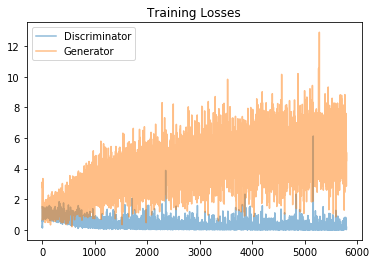

In [24]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

## Generator samples from training

View samples of images from the generator, and answer a question about the strengths and weaknesses of your trained models.

In [25]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [26]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

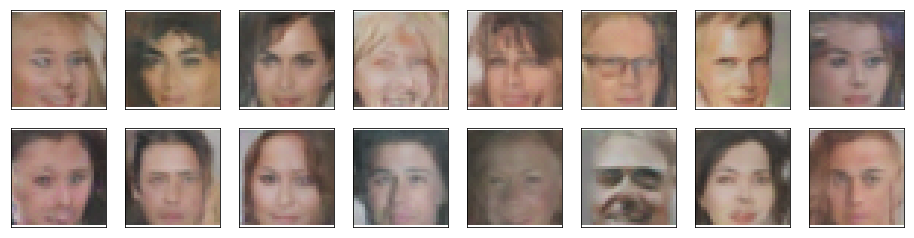

In [27]:
_ = view_samples(-1, samples)

### Question: What do you notice about your generated samples and how might you improve this model?
When you answer this question, consider the following factors:
* The dataset is biased; it is made of "celebrity" faces that are mostly white
* Model size; larger models have the opportunity to learn more features in a data feature space
* Optimization strategy; optimizers and number of epochs affect your final result


**Answer:** (Write your answer in this cell)
- The image quality is low, So we should do the following:
    - use larger images to improve the quality
    - change the strategy to cycle gan, to better initialize the generator
- This dataset is very biased, so we could gather more data like:
    - Non celebrity people
    - people with less makeup
    - data with more diversity
- Deeper convolutional layers with some resnet layers

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "problem_unittests.py" files in your submission.